In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.metrics import mean_squared_error

from kernels.nystrom import ImplicitNystromKernel
from kernels.nn import ImplicitDenseNetKernel
from kernels.kernel_fn import *
from model.ick import ICK, AdditiveICK
from utils.train import Trainer
from utils.helpers import *

import torch
from torch import optim
from gpytorch.kernels import LinearKernel, PeriodicKernel, SpectralMixtureKernel, RBFKernel
from gpytorch.priors import NormalPrior
from torch.distributions.multivariate_normal import MultivariateNormal

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Case 1: Both x1 and x2 are low-dimensional

## 1.1 Generate samples from GP with a non-separable kernel

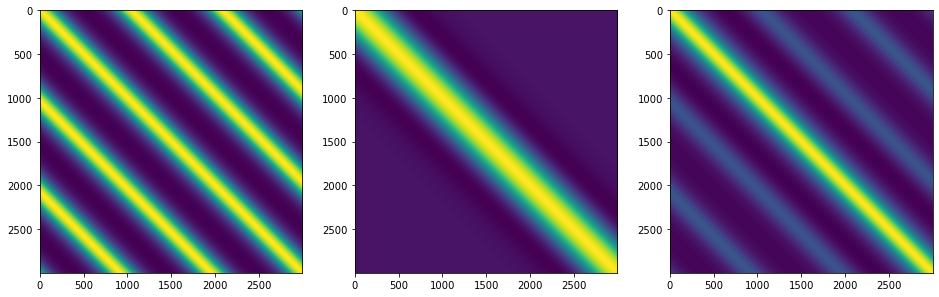

In [2]:
# Calculate the covariance matrix for periodic kernel
fig, axs = plt.subplots(1,3,figsize=(16,7))
N = 3000
x = torch.linspace(0,2,N).reshape(-1,1) # torch.rand(N,1)
cov_per_module = PeriodicKernel()
cov_per = cov_per_module(x).evaluate().detach()
axs[0].imshow(cov_per)
# Calculate the covariance matrix for spectral mixture kernel
t = torch.linspace(0,2,N).reshape(-1,1)
cov_sm_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_sm_module(t).evaluate().detach()
axs[1].imshow(cov_sm)
# Construct a nonseparable kernel
cov_nonsep = cov_per + cov_sm + cov_per*cov_sm + torch.eye(cov_per.shape[0])*1e-3
axs[2].imshow(cov_nonsep)

Text(0, 0.5, 'y')

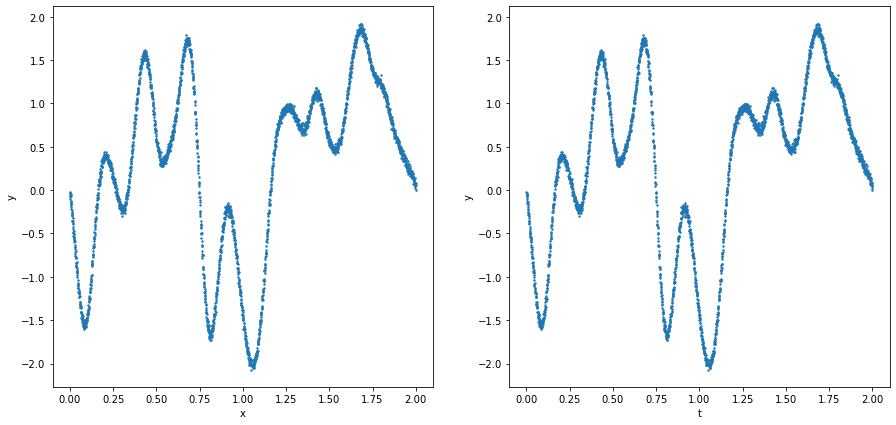

In [3]:
# Generate data points from GP with the nonseparable kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov_nonsep)
y = mv_normal_mul.sample()
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(torch.squeeze(x), y, s=2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].scatter(torch.squeeze(t), y, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')

In [4]:
# data, target = [x_transformed.numpy(), t.numpy()], y.numpy()
data, target = [x.numpy(), t.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

## 1.2 First, let's try ICK with a separable kernel (both Nystrom kernels)

In [ ]:
# Construct and train ICK with weighted nonseparable kernel
K_mul = ICK(
    # kernel_assignment=['ImplicitDenseNetKernel', 'ImplicitNystromKernel'], 
    kernel_assignment=['ImplicitNystromKernel', 'ImplicitNystromKernel'], 
    kernel_params = {
        'ImplicitNystromKernel':{
            'kernel_func': periodic_kernel_nys, 
            'params': ['std','period','lengthscale','noise'], 
            'vals': [0.1,0.2,0.25,1.], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,4.]]
        }, 
        'ImplicitNystromKernel': {
            'kernel_func': spectral_mixture_kernel_1d_nys, 
            'params': ['weight','mean','cov','noise'], 
            'vals': [[0.8,0.2],[0.5,0.5],[2.,0.5],0.1], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,2.]]
        }
    }
)
model = AdditiveICK(
    components=[K_mul], 
    component_assignment=[[0,1]], 
    coeffs=[1.], 
    weighted=[True]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 5e-5, 
    'momentum': 0.99,
    'weight_decay': 0
}
epochs, patience = 500, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

MSE: 0.1834


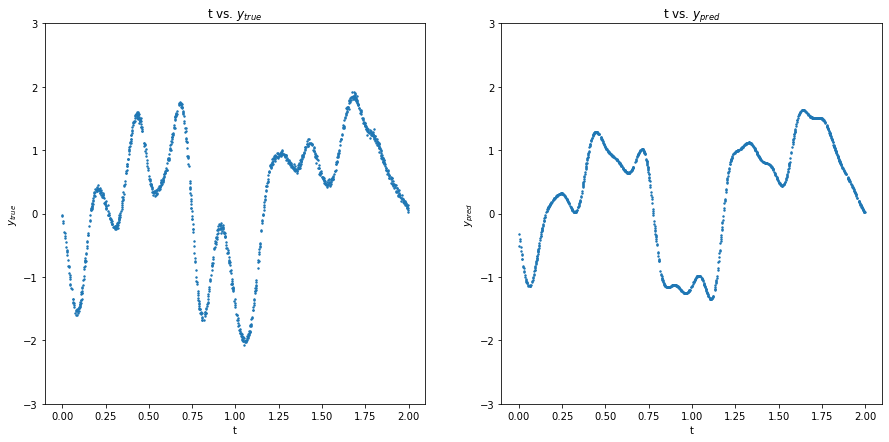

In [6]:
# Make predictions with ICKy
y_test_pred, y_test_true = trainer.predict()
t = np.squeeze(x_test[1])
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(t, y_test_true, s=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('$y_{true}$')
axs[0].set_title('t vs. $y_{true}$')
axs[0].set_ylim(-3,3)
axs[1].scatter(t, y_test_pred, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('$y_{pred}$')
axs[1].set_title('t vs. $y_{pred}$')
axs[1].set_ylim(-3,3)
mse_separable_ick = mean_squared_error(y_test_true, y_test_pred)
print("MSE: {:.4f}".format(mse_separable_ick))

## 1.3 Next, let's construct and train ICK with a nonseparable kernel

In [7]:
# Define components of the nonseparable kernel
K_per = ICK(
    kernel_assignment=['ImplicitNystromKernel'],
    kernel_params={
        'ImplicitNystromKernel':{
            'kernel_func': periodic_kernel_nys, 
            'params': ['std','period','lengthscale','noise'], 
            'vals': [0.1,0.2,0.25,1.], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,4.]]
        }
    }
)
K_sm = ICK(
    kernel_assignment=['ImplicitNystromKernel'],
    kernel_params={
        'ImplicitNystromKernel':{
            'kernel_func': spectral_mixture_kernel_1d_nys, 
            'params': ['weight','mean','cov','noise'], 
            'vals': [[0.8,0.2],[0.5,0.5],[2.,0.5],0.1], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,2.]]
        }
    }
)
K_mul = ICK(
    # kernel_assignment=['ImplicitDenseNetKernel', 'ImplicitNystromKernel'], 
    kernel_assignment=['ImplicitNystromKernel', 'ImplicitNystromKernel'], 
    kernel_params = {
        'ImplicitNystromKernel':{
            'kernel_func': periodic_kernel_nys, 
            'params': ['std','period','lengthscale','noise'], 
            'vals': [0.1,0.2,0.25,1.], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,4.]]
        }, 
        'ImplicitNystromKernel': {
            'kernel_func': spectral_mixture_kernel_1d_nys, 
            'params': ['weight','mean','cov','noise'], 
            'vals': [[0.8,0.2],[0.5,0.5],[2.,0.5],0.1], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,2.]]
        }
    }
)

In [ ]:
# Construct and train ICK with the nonseparable kernel
model = AdditiveICK(
    components=[K_per,K_sm,K_mul], 
    component_assignment=[[0],[1],[0,1]], 
    coeffs=[1.,1.,1.], 
    weighted=[True,True,True]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 5e-5, 
    'momentum': 0.99,
    'weight_decay': 0
}
epochs, patience = 500, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

MSE: 0.0459


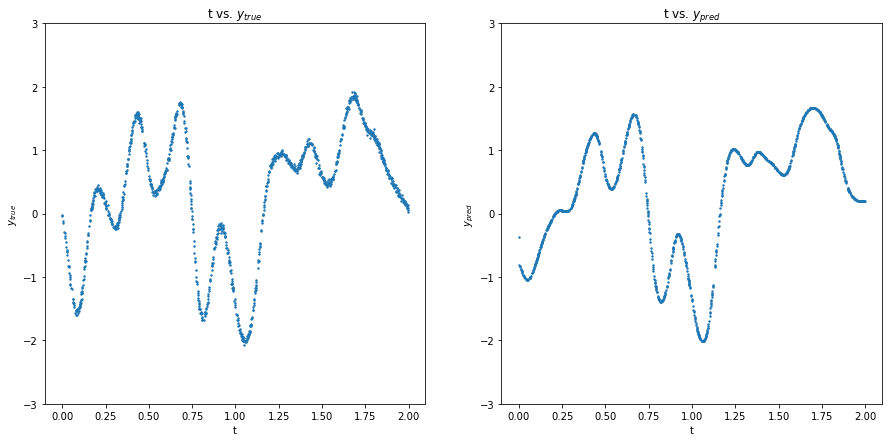

In [9]:
# Make predictions with ICKy
y_test_pred, y_test_true = trainer.predict()
t = np.squeeze(x_test[1])
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(t, y_test_true, s=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('$y_{true}$')
axs[0].set_title('t vs. $y_{true}$')
axs[0].set_ylim(-3,3)
axs[1].scatter(t, y_test_pred, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('$y_{pred}$')
axs[1].set_title('t vs. $y_{pred}$')
axs[1].set_ylim(-3,3)
mse_nonseparable_ick = mean_squared_error(y_test_true, y_test_pred)
print("MSE: {:.4f}".format(mse_nonseparable_ick))

We observe that nonseparable kernel captures the patterns in the data reasonably better than separable kernel.

# Case 2: x1 is high-dimensional and x2 is low-dimensional

## 2.1 Generate samples from GP with a non-separable kernel

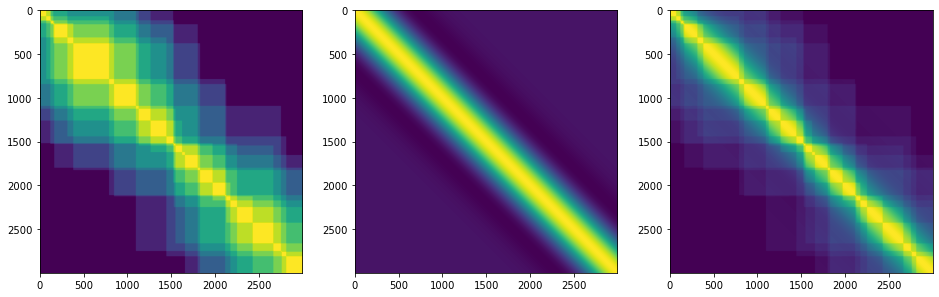

In [10]:
# Calculate the covariance matrix for linear kernel
fig, axs = plt.subplots(1,3,figsize=(16,7))
N = 3000
x = torch.linspace(0,4,N).reshape(-1,1) # torch.randn(N,1)
# Map x1 into high dimension
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x_transformed = torch.tensor(rt_model.fit_transform(np.array(x).reshape(-1,1)).toarray())
cov_lin_module = LinearKernel(ard_num_dims=x_transformed.shape[1])
cov_lin = cov_lin_module(x_transformed).evaluate().detach().float()
axs[0].imshow(cov_lin)
# Calculate the covariance matrix for spectral mixture kernel
t = torch.linspace(0,2,N).reshape(-1,1)
cov_sm_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_sm_module(t).evaluate().detach()
axs[1].imshow(cov_sm)
# Construct a nonseparable kernel
cov_nonsep = cov_lin + cov_sm + cov_lin*cov_sm + torch.eye(cov_lin.shape[0])*1e-3
axs[2].imshow(cov_nonsep)

Text(0, 0.5, 'y')

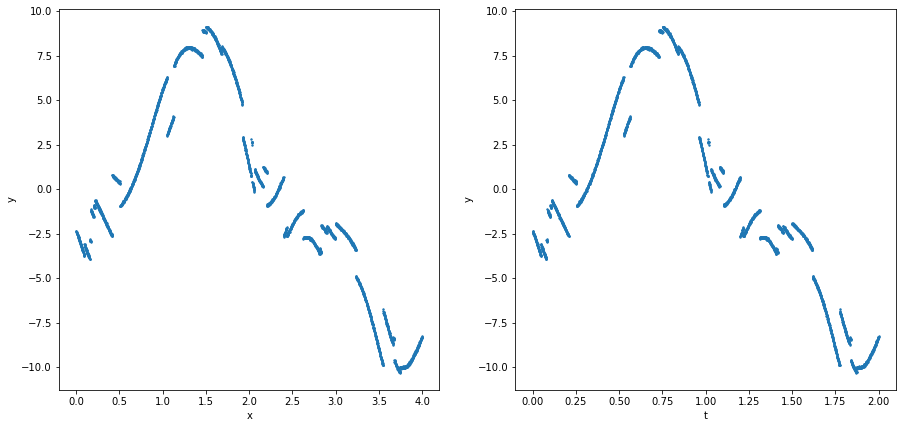

In [11]:
# Generate data points from GP with the nonseparable kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov_nonsep)
y = mv_normal_mul.sample()
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(torch.squeeze(x), y, s=2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].scatter(torch.squeeze(t), y, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')

In [12]:
data, target = [x_transformed.numpy(), t.numpy()], y.numpy()
# data, target = [x.numpy(), t.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

## 2.2 First, let's try ICK with a separable kernel (NN + Nystrom kernel)

In [ ]:
# Construct and train ICK with weighted nonseparable kernel
K_mul = ICK(
    kernel_assignment=['ImplicitDenseNetKernel', 'ImplicitNystromKernel'], 
    kernel_params = {
        'ImplicitDenseNetKernel':{
            'input_dim': 40,
            'latent_feature_dim': 16,
            'num_blocks': 1, 
            'num_layers_per_block': 1, 
            'num_units': 64
        }, 
        'ImplicitNystromKernel': {
            'kernel_func': spectral_mixture_kernel_1d_nys, 
            'params': ['weight','mean','cov','noise'], 
            'vals': [[0.8,0.2],[0.5,0.5],[2.,0.5],0.1], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,2.]]
        }
    }
)
model = AdditiveICK(
    components=[K_mul], 
    component_assignment=[[0,1]], 
    coeffs=[1.], 
    weighted=[False]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 1e-4, 
    'momentum': 0.99,
    'weight_decay': 0
}
epochs, patience = 500, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

MSE: 0.0033


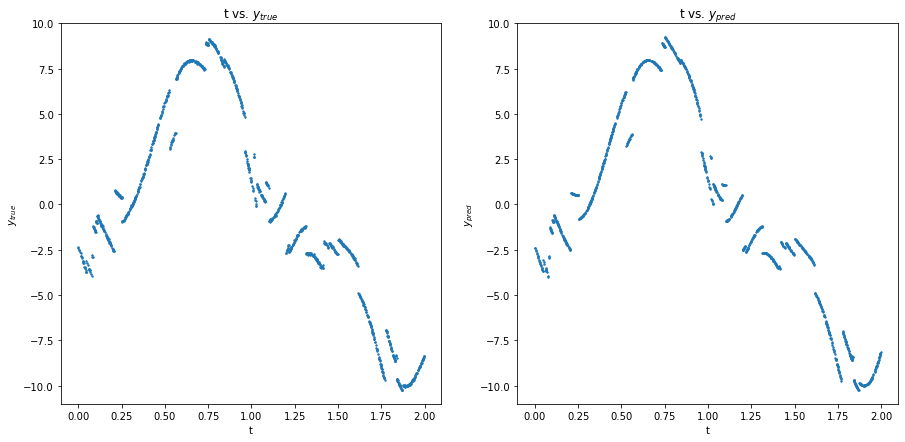

In [15]:
# Make predictions with ICKy
y_test_pred, y_test_true = trainer.predict()
t = np.squeeze(x_test[1])
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(t, y_test_true, s=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('$y_{true}$')
axs[0].set_title('t vs. $y_{true}$')
axs[0].set_ylim(-11,10)
axs[1].scatter(t, y_test_pred, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('$y_{pred}$')
axs[1].set_title('t vs. $y_{pred}$')
axs[1].set_ylim(-11,10)
mse_separable_ick = mean_squared_error(y_test_true, y_test_pred)
print("MSE: {:.4f}".format(mse_separable_ick))

We see that a separable kernel with NN already captures the data pattern really well!

## 2.3 Next, let's construct and train ICK with a nonseparable kernel

In [16]:
# Define components of the nonseparable kernel
K_nn = ICK(
    kernel_assignment=['ImplicitDenseNetKernel'],
    kernel_params={
        'ImplicitDenseNetKernel':{
            'input_dim': 40,
            'latent_feature_dim': 16,
            'num_blocks': 1, 
            'num_layers_per_block': 1, 
            'num_units': 64
        }
    }
)
K_sm = ICK(
    kernel_assignment=['ImplicitNystromKernel'],
    kernel_params={
        'ImplicitNystromKernel':{
            'kernel_func': spectral_mixture_kernel_1d_nys, 
            'params': ['weight','mean','cov','noise'], 
            'vals': [[0.8,0.2],[0.5,0.5],[2.,0.5],0.1], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,2.]]
        }
    }
)
K_mul = ICK(
    kernel_assignment=['ImplicitDenseNetKernel', 'ImplicitNystromKernel'], 
    kernel_params = {
        'ImplicitDenseNetKernel':{
            'input_dim': 40,
            'latent_feature_dim': 16,
            'num_blocks': 1, 
            'num_layers_per_block': 1, 
            'num_units': 64
        }, 
        'ImplicitNystromKernel': {
            'kernel_func': spectral_mixture_kernel_1d_nys, 
            'params': ['weight','mean','cov','noise'], 
            'vals': [[0.8,0.2],[0.5,0.5],[2.,0.5],0.1], 
            'trainable': [True,True,True,True], 
            'alpha': 1e-5, 
            'num_inducing_points': 16, 
            'nys_space': [[0.,2.]]
        }
    }
)

In [ ]:
# Construct and train ICK with the nonseparable kernel
model = AdditiveICK(
    components=[K_nn,K_sm,K_mul], 
    component_assignment=[[0],[1],[0,1]], 
    coeffs=[1.,1.,1.], 
    weighted=[False,True,False]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 1e-4, 
    'momentum': 0.99,
    'weight_decay': 0
}
epochs, patience = 500, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

MSE: 0.0038


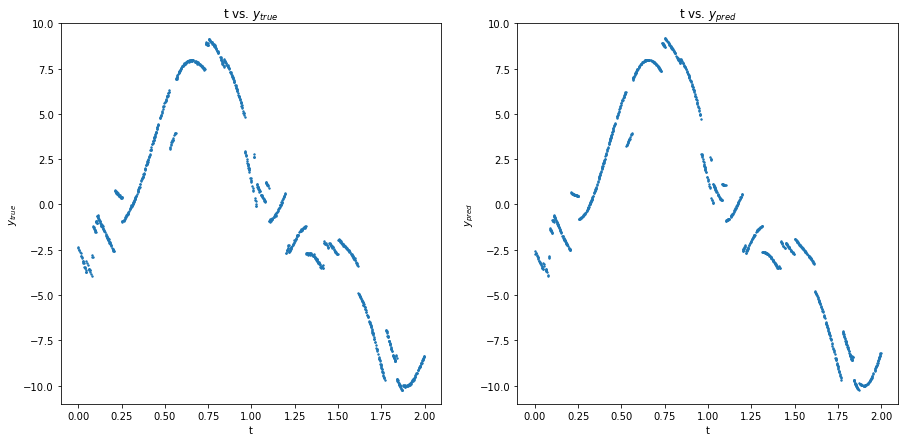

In [18]:
# Make predictions with ICKy
y_test_pred, y_test_true = trainer.predict()
t = np.squeeze(x_test[1])
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(t, y_test_true, s=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('$y_{true}$')
axs[0].set_title('t vs. $y_{true}$')
axs[0].set_ylim(-11,10)
axs[1].scatter(t, y_test_pred, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('$y_{pred}$')
axs[1].set_title('t vs. $y_{pred}$')
axs[1].set_ylim(-11,10)
mse_separable_ick = mean_squared_error(y_test_true, y_test_pred)
print("MSE: {:.4f}".format(mse_separable_ick))

We again see that ICK with nonseparable kernel performs slightly better than the one with separable kernel (though the performance of the separable kernel is already very good).